In [2]:
import pandas as pd
import json
import os
import ast
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('../../data/gpt4_mcq_eval.csv')
df.head()

,id,mcq_json,rubric,question,option_a,option_b,option_c,option_d,correct_option,content_gpt,originality,readability,starts_with_negation,is_question,relevance,ambiguity,gpt_answer,disclosure,difficulty
0,OIC-360-01-A,"{'question': 'What is a pneumothorax?', 'optio...",Definition,What is a pneumothorax?,Fluid accumulation in the lungs,Gas effusion in the pleural cavity,Infection of the pleural lining,Inflammation of the lung tissue,b,**Item Parent:** Pneumothorax \n**Title:** De...,0.000000,6.620000,False,True,0.789512,0.690330,b,False,5
1,OIC-360-08-A,{'question': 'Which of the following is a key ...,NaN,Which of the following is a key element in dia...,The size of the pneumothorax,Presence of respiratory distress,Patient's age,Location of the pneumothorax,b,**Item Parent:** Pneumothorax \n**Title:** Kn...,0.500000,11.500000,False,True,0.841534,0.621677,b,False,3
2,OIC-360-03-A,{'question': 'Which of the following is a clin...,Positive diagnosis,Which of the following is a clinical element u...,Sudden 'stabbing' chest pain,Increased vesicular murmur,Moist cough,Decreased tympany on percussion,a,**Item Parent:** Pneumothorax \n**Title:** Kn...,1.000000,12.690000,False,True,0.788986,0.566794,a,False,2
3,OIC-360-11-B,{'question': 'What is a recommended measure to...,NaN,What is a recommended measure to prevent the r...,Increasing physical activity,Smoking cessation,Reducing water intake,Avoiding dairy products,b,**Item Parent:** Pneumothorax \n**Title:** Kn...,0.333333,13.372727,False,True,0.826552,0.532753,b,True,2
4,OIC-360-10-B,{'question': 'What is a primary indication for...,Management,What is a primary indication for performing pl...,When the pneumothorax is primary and exsufflat...,When the pneumothorax is primary and there is ...,When the pneumothorax is secondary and exsuffl...,When the pneumothorax is primary and there is ...,a,**Item Parent:** Pneumothorax \n**Title:** Kn...,1.000000,15.155714,False,True,0.877802,0.816469,a,False,2


In [14]:
# normalize correct_option
df['correct_option'] = df['correct_option'].replace({'option_b': 'b', 'option_c': 'c', 'option_d': 'd'}) 

# Question mark

In [15]:
# We want to maximize 'True'
question_count = {
    'True': df['is_question'].sum(),
    'False': len(df) - df['is_question'].sum()
}

question_count

{'True': np.int64(4693), 'False': np.int64(0)}

# Negation

In [16]:
# We want to minimze 'True'
starts_with_negation_count = {
    'True': df['starts_with_negation'].sum(),
    'False': len(df) - df['starts_with_negation'].sum()
}

starts_with_negation_count

{'True': np.int64(0), 'False': np.int64(4693)}

# Originality

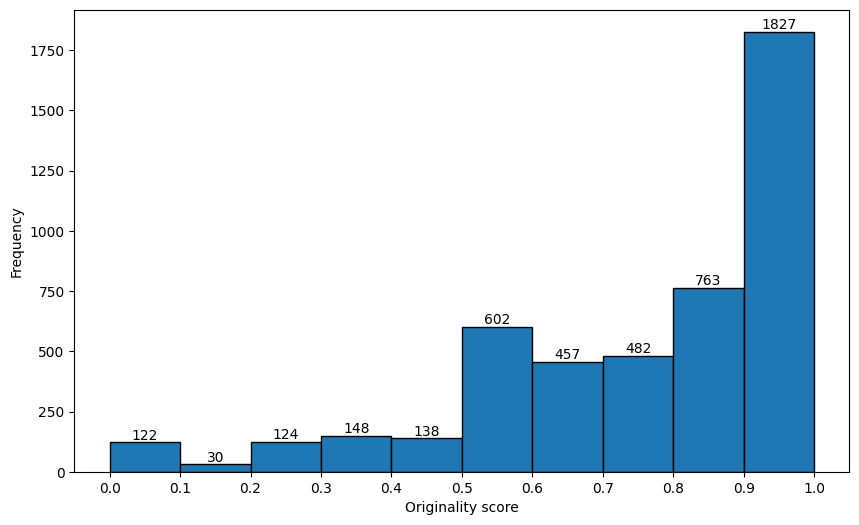

In [17]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['originality'], bins=10, range=(0, 1), edgecolor='black')

plt.xticks([round(x * 0.1, 1) for x in range(11)])

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')

plt.xlabel('Originality score')
plt.ylabel('Frequency')
plt.show()

# Readability

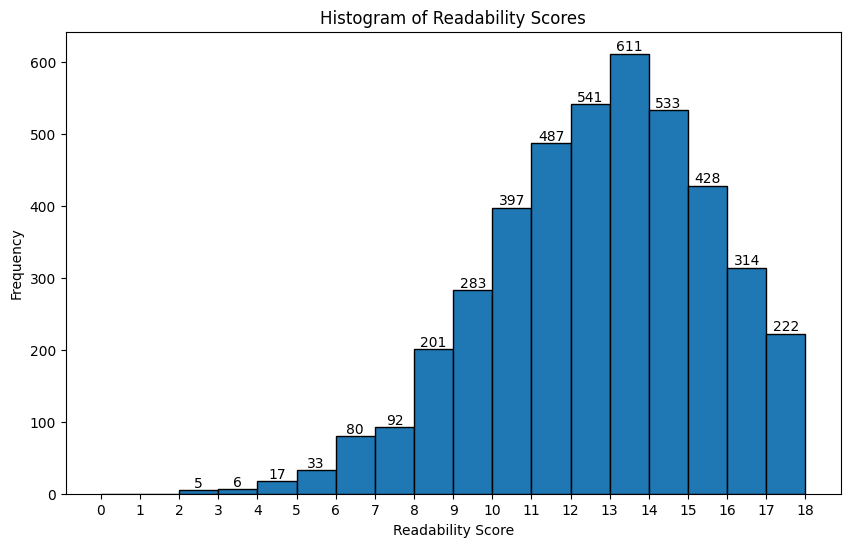

In [18]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['readability'], bins=range(0, 19, 1), edgecolor='black')

# Set x-axis ticks from 0 to 18
plt.xticks(range(0, 19))

# Add frequency labels on top of each bar where frequency > 0
for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')
plt.xlabel('Readability Score')
plt.ylabel('Frequency')
plt.title('Histogram of Readability Scores')
plt.show()

# Answer Length

In [19]:
option_cols = ['option_a', 'option_b', 'option_c', 'option_d']

# Create new columns with word counts for each option column
for col in option_cols:
    df[f'{col}_word_count'] = df[col].astype(str).apply(lambda x: len(x.split()))

In [20]:
def get_correct_option_rank(row):
    # Get the original word counts for each option
    counts = [
        row['option_a_word_count'],
        row['option_b_word_count'],
        row['option_c_word_count'],
        row['option_d_word_count']
    ]

    # Map correct_option letter to its index (0 for A, 1 for B, etc.)
    letter_to_index = {'A': 0, 'a':0, 'B': 1, 'b':1, 'C': 2, 'c':2, 'D': 3, 'd':3}
    correct_idx = letter_to_index[row['correct_option']]

    # Determine the word count of the correct option
    correct_count = counts[correct_idx]

    # Create an effective counts list:
    # For non-correct options, if their word count equals the correct option's word count,
    # treat them as if they had one extra word.
    effective_counts = []
    for i, count in enumerate(counts):
        if i != correct_idx and count == correct_count:
            effective_counts.append(count + 1)
        else:
            effective_counts.append(count)

    # Sort the option indices by descending effective count.
    ordering = sorted(range(4), key=lambda i: effective_counts[i], reverse=True)

    # Compute the rank as the 1-indexed position of the correct option in the ordering.
    rank = ordering.index(correct_idx) + 1
    return rank

In [21]:
def get_rank_distribution(df):
  rank_distribution = df['correct_option_rank'].value_counts().sort_index()
  rank_distribution = round(rank_distribution / len(df), 2) * 100

  plt.figure(figsize=(8, 6))
  plt.bar(rank_distribution.index, rank_distribution.values, color='skyblue', edgecolor='black')
  plt.xlabel('N (1 = Longest, 4 = Shortest)')
  plt.ylabel('Frequency, %')
  plt.title('How often the correct option is N`th longest')
  plt.xticks([1, 2, 3, 4])
  plt.show()

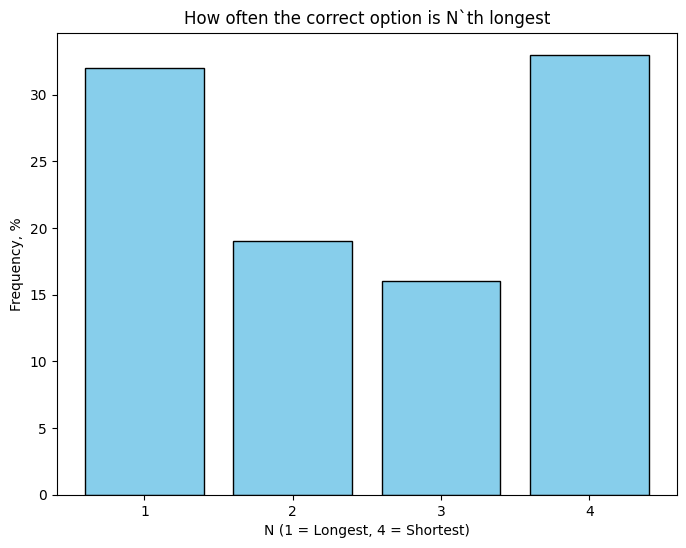

In [22]:
df['correct_option_rank'] = df.apply(get_correct_option_rank, axis=1)
get_rank_distribution(df)

# Disclosure

In [23]:
disclosure_count = {
    'True': df['disclosure'].sum(),
    'False': len(df) - df['disclosure'].sum()
}

disclosure_count

{'True': np.int64(459), 'False': np.int64(4234)}

# Relevance to the input material

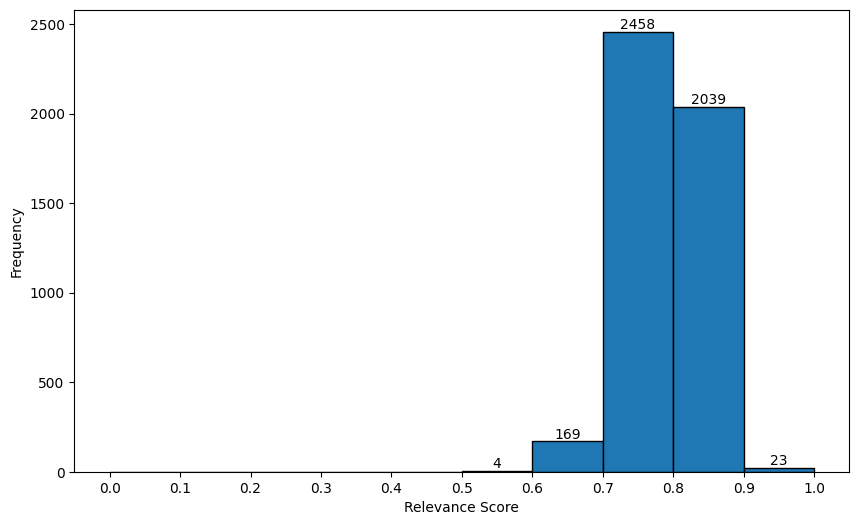

In [24]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['relevance'], bins=10, range=(0, 1), edgecolor='black')

plt.xticks([round(x * 0.1, 1) for x in range(11)])

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')

plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()

# Ambiguity (cosine similarity)

Text(0.5, 1.0, 'Distribution of Ambiguity')

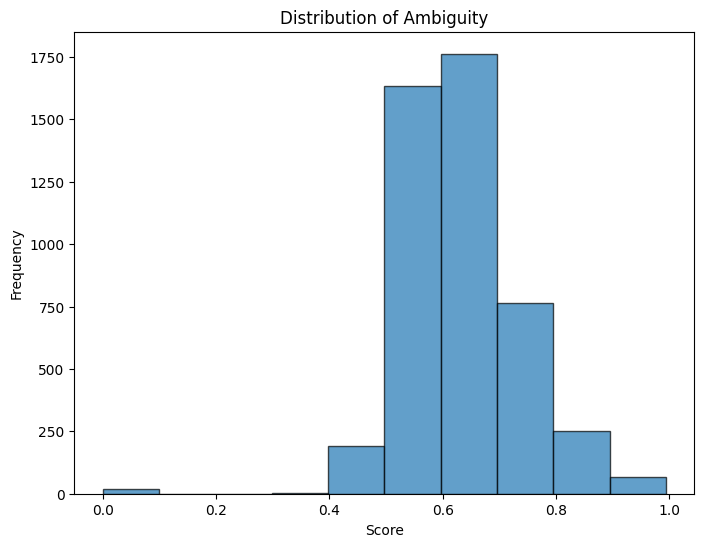

In [27]:
plt.figure(figsize=(8, 6))
plt.hist(df['ambiguity'], bins=10, edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Ambiguity")

# Difficulty (judge LLM)

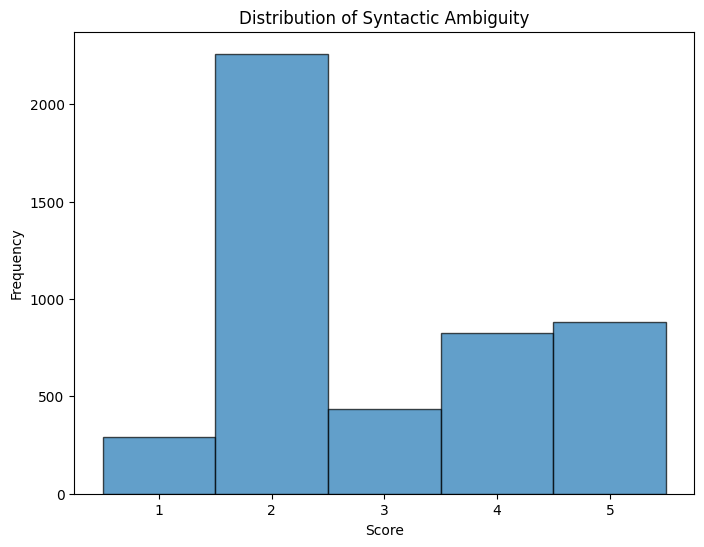

In [28]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['difficulty'], bins=np.arange(1, 7)-0.5, edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Syntactic Ambiguity")
plt.xticks(range(1, 6))

# Show the plot
plt.show()

# Answerability
can judge model answer the generated question with context provided?

In [29]:
df['gpt_answer'].unique()

array(['b', 'a', 'c', 'd'], dtype=object)

In [30]:
df['correct_option'].unique()

array(['b', 'a', 'c', 'd'], dtype=object)

In [31]:
answerability_count = {
    'True': (df['correct_option'] == df['gpt_answer']).sum(),
    'False': len(df) - (df['correct_option'] == df['gpt_answer']).sum()
}

answerability_count

{'True': np.int64(4679), 'False': np.int64(14)}